In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from TrackSelectorDNN.models.track_classifier import TrackClassifier
from TrackSelectorDNN.data_manager.dataset_factory import get_dataset
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from torch.utils.data import DataLoader

Manually look for the best model

In [2]:
run_root = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/03c88_00000/"
best_val = float("inf")
best_ckpt_path = None
best_config = None

for trial_name in range(1):# os.listdir(run_root):
    #trial_dir = os.path.join(run_root, trial_name)
    trial_dir = run_root
    metrics_file = os.path.join(trial_dir, "best_metrics.json")
    ckpt_file = os.path.join(trial_dir, "best_model.pt")

    if os.path.exists(metrics_file):
        with open(metrics_file, "r") as f:
            metrics = json.load(f)
        if metrics["val_loss"] < best_val:
            best_metrics = metrics
            best_val = metrics["val_loss"]
            best_ckpt_path = ckpt_file
            # optionally save config
            config_file = os.path.join(trial_dir, "config.yaml")
            best_config = config_file if os.path.exists(config_file) else None

print("Best checkpoint:", best_ckpt_path)
print("Best val_loss:", best_val)
print("Best config file:", best_config)

Best checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/03c88_00000/best_model.pt
Best val_loss: 0.18015238338843012
Best config file: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/03c88_00000/config.yaml


In [3]:
metrics

{'epoch': 5,
 'train_loss': 0.18910536027251532,
 'val_loss': 0.18015238338843012,
 'val_acc': 0.9232773298869674}

In [4]:
import yaml

# Open and load YAML
with open(best_config, "r") as f:
    best_config = yaml.safe_load(f)

Load the validation dataset

In [5]:
best_config["val_path"] = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train-val_dataset.pt'

best_config["val_path"]

'/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train-val_dataset.pt'

In [6]:
val_ds, collate_fn = get_dataset(best_config, dataset_role="val_path")
device = "cpu" #"cuda" if torch.cuda.is_available() else
val_loader = DataLoader(val_ds, batch_size=best_config["batch_size"], collate_fn=collate_fn)

build the model

In [7]:
model = TrackClassifier(hit_input_dim = best_config["hit_input_dim"],
                        track_feat_dim = best_config["track_feat_dim"],
                        latent_dim = best_config["latent_dim"],
                        pooling_type = best_config["pooling_type"],
                        # --- NetA parameters ---
                        netA_hidden_dim = best_config["netA_hidden_dim"],
                        netA_hidden_layers = best_config["netA_hidden_layers"],
                        netA_batchnorm = best_config["netA_batchnorm"],
                        netA_activation = best_config["netA_activation"],
                        # --- NetB parameters ---
                        netB_hidden_dim = best_config["netB_hidden_dim"],
                        netB_hidden_layers = best_config["netB_hidden_layers"],
                        netB_batchnorm = best_config["netB_batchnorm"],
                        netB_activation = best_config["netB_activation"]).to(device)


model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
model.eval()

TrackClassifier(
  (pool): MeanPooling()
  (netA): NetA(
    (mlp): Sequential(
      (0): Linear(in_features=9, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (netB): NetB(
    (mlp): Sequential(
      (0): Linear(in_features=87, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [8]:
def plot_run_losses(run_dir):
    log_file = os.path.join(run_dir, "metrics.csv")  # or whatever CSVLogger writes
    if not os.path.exists(log_file):
        raise FileNotFoundError(f"No metrics.csv found in {run_dir}")

    df = pd.read_csv(log_file)

    # Assumes columns: epoch, train_loss, val_loss
    epochs = df["epoch"]
    train_loss = df["train_loss"]
    val_loss = df["val_loss"]

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")

    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()


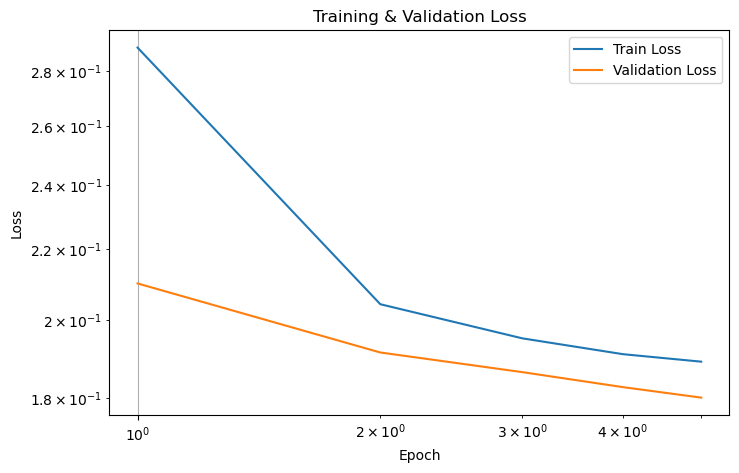

In [9]:
plot_run_losses("/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/03c88_00000/")

Rerun inference on validation

In [10]:
all_preds = []
all_labels = []
all_isHighPurity = []

with torch.no_grad():
    for batch in val_loader:
        hit_features = batch["hit_features"].to(device)
        track_features = batch["track_features"].to(device)
        mask = batch["mask"].to(device)
        labels = batch["labels"].cpu().numpy()

        preds = model(hit_features, track_features, mask).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

# Load the legacy classifier output from the dataset
all_isHighPurity = val_ds.isHighPurity.numpy()  # fix


In [11]:
# ROC curve
fpr_dnn, tpr_dnn, _ = roc_curve(all_labels, all_preds)
auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_hp, tpr_hp, _ = roc_curve(all_labels, all_isHighPurity)
auc_hp = auc(fpr_hp, tpr_hp)

# Accuracy and confusion matrix for DNN
preds_bin = (all_preds > 0.5).astype(int)
acc_dnn = accuracy_score(all_labels, preds_bin)
tn, fp, fn, tp = confusion_matrix(all_labels, preds_bin).ravel()

print(f"✅ DNN Results:")
print(f"  AUC: {auc_dnn:.4f}")
print(f"  Accuracy: {acc_dnn:.4f}")
print(f"  True Positives:  {tp}")
print(f"  False Positives: {fp}")
print(f"  True Negatives:  {tn}")
print(f"  False Negatives: {fn}")

✅ DNN Results:
  AUC: 0.9643
  Accuracy: 0.9229
  True Positives:  147708
  False Positives: 10419
  True Negatives:  20992
  False Negatives: 3682


In [12]:
# Accuracy for legacy classifier
acc_hp = accuracy_score(all_labels, all_isHighPurity)
tn_hp, fp_hp, fn_hp, tp_hp = confusion_matrix(all_labels, all_isHighPurity).ravel()

print(f"\n✅ Legacy (isHighPurity) Results:")
print(f"  AUC: {auc_hp:.4f}")
print(f"  Accuracy: {acc_hp:.4f}")
print(f"  True Positives:  {tp_hp}")
print(f"  False Positives: {fp_hp}")
print(f"  True Negatives:  {tn_hp}")
print(f"  False Negatives: {fn_hp}")


✅ Legacy (isHighPurity) Results:
  AUC: 0.6544
  Accuracy: 0.8710
  True Positives:  149022
  False Positives: 21222
  True Negatives:  10189
  False Negatives: 2368


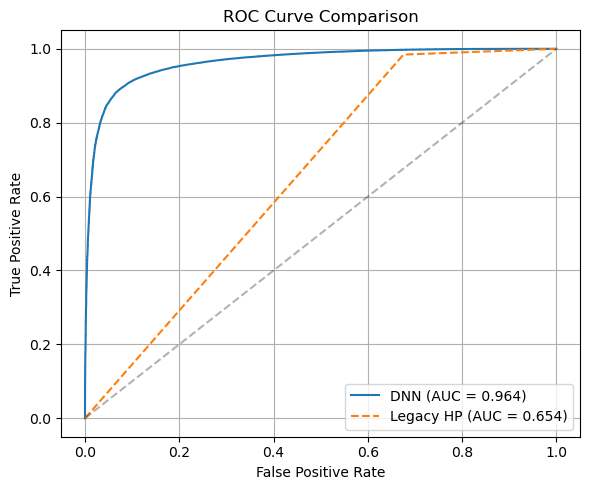

In [13]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_dnn, tpr_dnn, label=f"DNN (AUC = {auc_dnn:.3f})")
plt.plot(fpr_hp, tpr_hp, label=f"Legacy HP (AUC = {auc_hp:.3f})", linestyle="--")
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

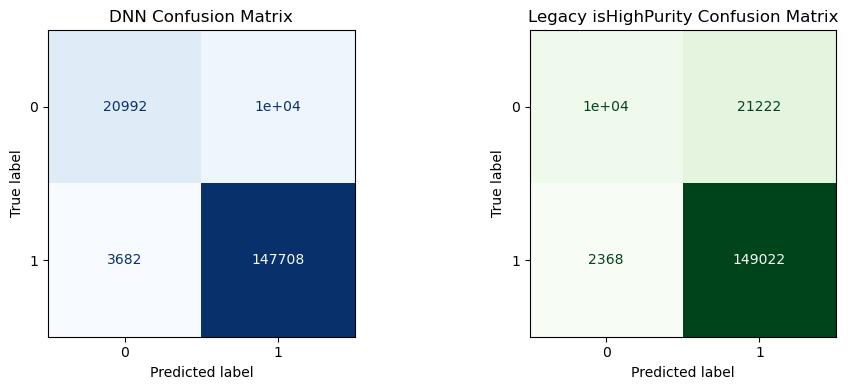

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(confusion_matrix(all_labels, preds_bin)).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("DNN Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(all_labels, all_isHighPurity)).plot(
    ax=axes[1], cmap="Greens", colorbar=False
)
axes[1].set_title("Legacy isHighPurity Confusion Matrix")

for ax in axes:
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

In [16]:
# --- Fake rate computation with Poisson errors ---
def compute_fake_rate(y_true, y_pred_bin, eta, bins):
    fake_rate = np.full(len(bins) - 1, np.nan)
    fake_rate_err = np.full(len(bins) - 1, np.nan)
    for i in range(len(bins) - 1):
        sel = (eta >= bins[i]) & (eta < bins[i + 1])
        if sel.sum() == 0:
            continue
        predicted_real = y_pred_bin[sel] == 1
        if predicted_real.sum() == 0:
            continue
        fake = ((y_true[sel] == 0) & predicted_real).sum()
        total = predicted_real.sum()

        fake_rate[i] = fake / total
        # Poisson error: σ ≈ sqrt(N_fake) / N_total
        fake_rate_err[i] = np.sqrt(fake) / total if fake > 0 else 1.0 / total
    return fake_rate, fake_rate_err


# --- Efficiency computation with Poisson errors ---
def compute_efficiency(y_true, y_pred_bin, eta, bins):
    eff = np.full(len(bins) - 1, np.nan)
    eff_err = np.full(len(bins) - 1, np.nan)
    for i in range(len(bins) - 1):
        sel = (eta >= bins[i]) & (eta < bins[i + 1])
        true_sel = sel & (y_true == 1)
        n_true = true_sel.sum()
        if n_true == 0:
            continue
        passed = (y_pred_bin[true_sel] == 1).sum()
        eff[i] = passed / n_true
        # Poisson error: σ ≈ sqrt(N_passed) / N_total
        eff_err[i] = np.sqrt(passed) / n_true if passed > 0 else 1.0 / n_true
    return eff, eff_err


# --- Compute metrics and errors ---
eta_idx = val_ds.recoPixelTrackBranches.index("hltPixelTrack_eta")
eta_vals = val_ds.recoPixelTrackFeatures[:, eta_idx].numpy()

# Threshold model outputs
preds_bin = (all_preds > 0.5).astype(int)
labels = all_labels.astype(int)
hp = all_isHighPurity.astype(int)

# Define η bins
eta_bins = np.linspace(-3, 3, 30)
eta_centers = 0.5 * (eta_bins[:-1] + eta_bins[1:])
fake_rate_dnn, fake_rate_dnn_err = compute_fake_rate(labels, preds_bin, eta_vals, eta_bins)
fake_rate_hp,  fake_rate_hp_err  = compute_fake_rate(labels, hp, eta_vals, eta_bins)
eff_dnn, eff_dnn_err = compute_efficiency(labels, preds_bin, eta_vals, eta_bins)
eff_hp,  eff_hp_err  = compute_efficiency(labels, hp, eta_vals, eta_bins)

eta_centers = 0.5 * (eta_bins[:-1] + eta_bins[1:])

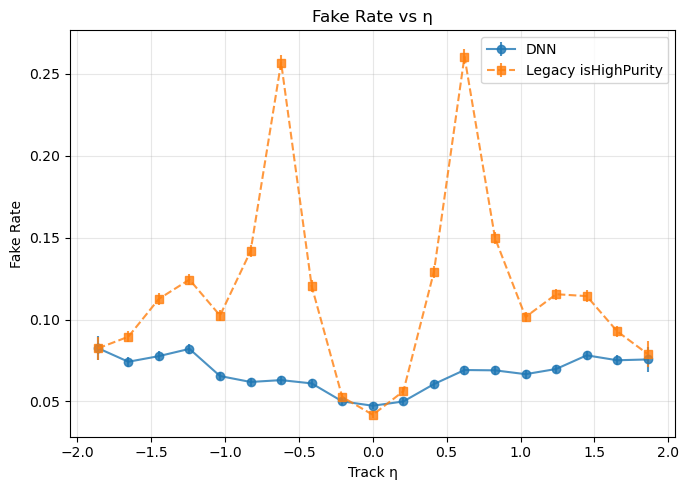

In [22]:
# --- Plot Fake Rate ---
plt.figure(figsize=(7,5))
plt.errorbar(eta_centers, fake_rate_dnn, yerr=fake_rate_dnn_err, fmt='o-', label='DNN', alpha=0.8)
plt.errorbar(eta_centers, fake_rate_hp,  yerr=fake_rate_hp_err,  fmt='s--', label='Legacy isHighPurity', alpha=0.8)
plt.xlabel('Track η')
plt.ylabel('Fake Rate')
plt.title('Fake Rate vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
#plt.yscale('log')
plt.show()

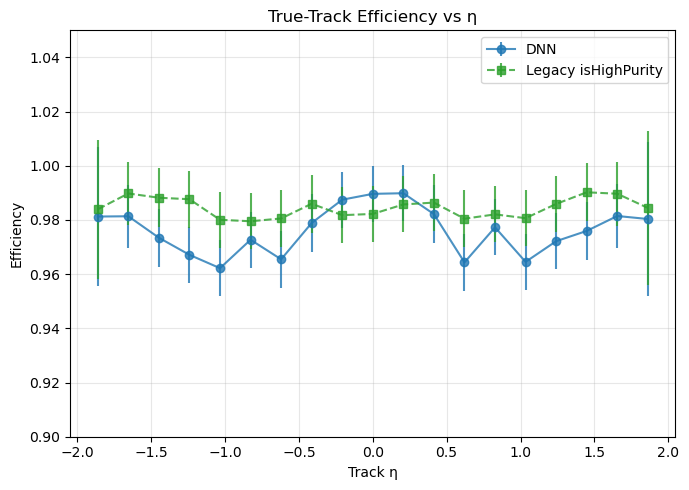

In [21]:
# --- Plot Efficiency ---
plt.figure(figsize=(7,5))
plt.errorbar(eta_centers, eff_dnn, yerr=eff_dnn_err, fmt='o-', label='DNN', color='tab:blue', alpha=0.8)
plt.errorbar(eta_centers, eff_hp,  yerr=eff_hp_err,  fmt='s--', label='Legacy isHighPurity', color='tab:green', alpha=0.8)
plt.xlabel('Track η')
plt.ylabel('Efficiency')
plt.title('True-Track Efficiency vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0.9, 1.05)
plt.tight_layout()
plt.show()